In [1]:
# !pip install catboost
# !pip install lightgbm
# !pip install feather-format

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import random
import gc
import lightgbm as lgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import feather
import os
import glob
import csv   
from sklearn.metrics import mean_squared_error

Set seed

In [3]:
seed = 7
random.seed(seed)
np.random.seed(seed)

# Load data

In [4]:
%%time
path = '../data'
train = feather.read_dataframe(f'{path}/Prepared_data/train_filled_na_light.feather')
train['meter_reading_log'] = np.log1p(train['meter_reading'])
train.drop(columns=['utc','altitude','azimuth'], inplace=True)

gc.collect()

CPU times: user 8.76 s, sys: 12.7 s, total: 21.5 s
Wall time: 25.1 s


7

# Add median values to train

In [5]:
print(train.shape)
train = train[(train['suspicious_1'] + train['suspicious_2'] + train['suspicious_3']).eq(0)]
train.drop(columns=['suspicious_1','suspicious_2','suspicious_3'],inplace=True)

print(train.shape)
rows_to_drop = pd.read_csv(f'{path}/Prepared_data/rows_to_drop.csv')['0']
train = train[~train['row_id'].isin(rows_to_drop)]
print(train.shape)
gc.collect()

(20216100, 66)
(18562599, 63)
(18109925, 63)


0

In [6]:
min_max = train.groupby(['building_id','meter'])['meter_reading_log'].agg(['median','min','max','std'])
min_max.columns = ['meter_' + c for c in min_max.columns]
min_max = min_max.reset_index()

train['hour'] = train['utc_time'].dt.hour

min_max_by_hour = train.groupby(['building_id','meter','hour'])['meter_reading_log'].agg(['median','min','max','std'])
min_max_by_hour.columns = ['meter_hour_' + c for c in min_max_by_hour.columns]
min_max_by_hour = min_max_by_hour.reset_index()

train = pd.merge(train,min_max_by_hour, on=['building_id','meter','hour'], how='left')
train = pd.merge(train,min_max, on=['building_id','meter'], how='left')

min_max.to_feather(f'{path}/Prepared_data/min_max.feather')
min_max_by_hour.to_feather(f'{path}/Prepared_data/min_max_by_hour.feather')

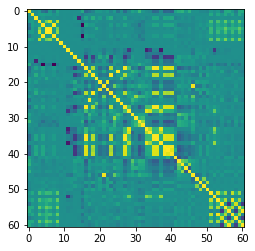

In [7]:
im = train.corr()

plt.imshow(im)
plt.show()

In [8]:
for c in im.columns : 
    high_corr = im[c][im[c].gt(0.9)].index
    for c_2 in high_corr:
        if c_2 != c:
            print(c,c_2)

year_built new_year_built
floor_count new_floor_count
new_floor_count floor_count
new_year_built year_built
air_temperature new_air_temperature
air_temperature feels_like
air_temperature new_feels_like
air_temperature air_temperature_mean_lag72
cloud_coverage new_cloud_coverage
dew_temperature new_dew_temperature
sea_level_pressure new_sea_level_pressure
wind_speed beaufort_scale
new_sea_level_pressure sea_level_pressure
new_dew_temperature dew_temperature
new_cloud_coverage cloud_coverage
new_air_temperature air_temperature
new_air_temperature feels_like
new_air_temperature new_feels_like
new_air_temperature air_temperature_mean_lag72
uvIndex irradiance
irradiance uvIndex
irradiance radiation
feels_like air_temperature
feels_like new_air_temperature
feels_like new_feels_like
feels_like air_temperature_mean_lag72
new_feels_like air_temperature
new_feels_like new_air_temperature
new_feels_like feels_like
new_feels_like air_temperature_mean_lag72
radiation irradiance
air_temperature_mean

# Create train test split

Features

In [9]:
features = ['site_id',
             'meter',
             'primary_use',
             'square_feet',
             'new_floor_count',
             'is_holiday',
             # 'weekday_cos',
             # 'weekday_sin',
             'weekday',
             # 'hour_cos',
             # 'hour_sin',
             'year_cos',
             'year_sin',
             'is_day_saving',
             'air_temperature',
             'age',
             'dew_temperature',
             # 'sea_level_pressure',
             # 'new_sea_level_pressure',
             'new_dew_temperature',
             # 'new_wind_speed',
             'new_air_temperature',
             # 'humidity',
             'latitude',
             # 'irradiance',
             'feels_like',
             'new_feels_like',
             # 'radiation',
             'air_temperature_mean_lag72',
             'air_temperature_max_lag72',
             'air_temperature_min_lag72',
             # 'air_temperature_std_lag72',
             'cloudCover_mean_lag72',
             # 'cloudCover_std_lag72',
             # 'new_wind_direction_cos',
             # 'new_wind_direction_sin',
             # 'cloudCover',
             # 'irradiance_cloud',
             # 'cloudCover_max_lag72',
             # 'wind_direction_cos',
             # 'wind_direction_sin',
             # 'cloud_coverage',
             'meter_median',
             'meter_max',
             'meter_std',
             'meter_hour_median',
             'meter_hour_min',
             'meter_hour_max',
             'meter_hour_std',
           ]
             # 'building_id',
             # 'floor_count',
             # 'night_time',
             # 'wind_speed',
             # 'longitude',
             # 'square_feet_log',
             # 'cloudCover_min_lag72',
             # 'precip_depth_1_hr',
             # 'meter_reading_log'
             # 'split'
             # 'meter_reading',  
             # 'timestamp',             
             # 'beaufort_scale',
             # 'suspicious_1',
             # 'suspicious_2',
             # 'new_cloud_coverage',
             # 'uvIndex'
             # 'afternoon',
             # 'year_built',
             # 'new_year_built',
             # 'new_precip_depth_1_hr',
             # 'morning',
             # 'evening',

target = 'meter_reading_log'

In [ ]:
import pickle
model = pickle.load('./models/lgbm_v_40_fold_all.bin')

In [10]:
for f in ['primary_use','is_day_saving','is_holiday','building_id','meter','site_id','weekday']:
    train[f] = train[f].astype('category')

# Train model

In [11]:
n_split = 4
version = '41'
model_name = 'lgbm'

#### Create CV 

In [12]:
cv_method = 'stratified_site_id_quarter'
train['split'] = (train['site_id'].astype(int) + (train['utc_time'].dt.month -1)%4 - 1) % n_split

In [13]:
# group = train['site_id'].astype(str) + "_" + (train['timestamp'].dt.month).astype(str)
# groupSplit = GroupShuffleSplit(n_split, test_size=0.2, random_state=7)
# folds = groupSplit.split(train[['radiation']],
#                          train['meter_reading'],
#                          groups=[train['site_id'],train['timestamp'].dt.month])

# LightGBM

In [14]:
lgb_params =  {'objective': 'regression',
 'metric': 'rmse',
 'n_jobs': -1,
 'learning_rate': 0.005,
 'num_leaves': 256,
 'max_depth': -1,
 'tree_learner': 'serial',
 'colsample_bytree': 0.9,
 'subsample': 0.5,
 'max_bin': 50,
 'verbose': 2,
 'boosting_type': 'goss',
 'subsample_freq': 0,
 'n_estimators':650,
 'seed': seed,
 'top_rate': 0.5,
 'other_rate': 0.4,
 'early_stopping_rounds':100 }


mean_performance_test = 0 
mean_performance_train = 0
mean_performance_leaked = 0
gc.collect()

2508

In [15]:
for fold in range(n_split):  
    print(f"\n\n\n ===== Fold numer {fold} =====")
    tr_data = lgb.Dataset(train.loc[train['split'].ne(fold)][features], 
                          label=train.loc[train['split'].ne(fold)][target])
    vl_data = lgb.Dataset(train.loc[train['split'].eq(fold)][features], 
                          label=train.loc[train['split'].eq(fold)][target])
    gc.collect()
    estimator = lgb.train(
                lgb_params,
                tr_data,
                valid_sets = [tr_data,vl_data],
                verbose_eval = 50)
    model_filename = 'models/' + model_name + '_v_' + str(version) + "_" + cv_method + '_fold_' + str(fold)  + '.bin'
    pickle.dump(estimator, open(model_filename, 'wb'))

    performance_test = estimator.best_score['valid_1']['rmse']
    performance_train = estimator.best_score['training']['rmse']

    mean_performance_test += performance_test
    mean_performance_train += performance_train

#     i = 0
#     step = 100000
#     test['pred'] = np.nan
#     while i < test.shape[0]:
#         test.loc[i:(i+step-1),'pred'] = estimator.predict(test.iloc[i:(i+step)][features])
#         i = i + step
#         gc.collect()
#     print("Done with the test prediction")

#     performance_leaked = np.sqrt(mean_squared_error(test['meter_reading_log'],test['pred']))
#     mean_performance_leaked += performance_leaked
#     print((mean_performance_train/(fold+1)),(mean_performance_test/(fold+1)),(mean_performance_leaked/(fold+1)))

    with open(r'./models/perf_leaked.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([model_filename, fold, performance_train, performance_test, 0, version])

    print((mean_performance_train/(fold+1)),(mean_performance_test/(fold+1)))




 ===== Fold numer 0 =====


/Users/palg166k/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/palg166k/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.6107	valid_1's rmse: 1.6039
[100]	training's rmse: 1.35918	valid_1's rmse: 1.36345
[150]	training's rmse: 1.17497	valid_1's rmse: 1.18941
[200]	training's rmse: 1.04124	valid_1's rmse: 1.06532
[250]	training's rmse: 0.943264	valid_1's rmse: 0.976972
[300]	training's rmse: 0.874016	valid_1's rmse: 0.91602
[350]	training's rmse: 0.824923	valid_1's rmse: 0.874004
[400]	training's rmse: 0.789481	valid_1's rmse: 0.845484
[450]	training's rmse: 0.762024	valid_1's rmse: 0.82437
[500]	training's rmse: 0.740361	valid_1's rmse: 0.808521
[550]	training's rmse: 0.723797	valid_1's rmse: 0.797473
[600]	training's rmse: 0.709216	valid_1's rmse: 0.787973
[650]	training's rmse: 0.697122	valid_1's rmse: 0.780606
Did not meet early stopping. Best iteration is:
[650]	training's rmse: 0.697122	valid_1's rmse: 0.780606
0.6971220132360484 0.7806061859395836



 ===== Fold numer 1 =====
Training until validation scores don't

In [16]:
mean_performance_leaked = mean_performance_leaked/n_split
mean_performance_test = mean_performance_test/n_split
mean_performance_train = mean_performance_train/n_split

with open(r'./models/perf_leaked.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([model_filename, 'avg', mean_performance_train, mean_performance_test, 0, version])

# Feature importance

In [17]:
models = []

path = f'models/lgbm_v_{version}_{cv_method}_fold_'

for i in range(n_split):
    m = path + str(i) + '.bin'
    models.append(pickle.load(open(m,'rb')))

In [18]:
feature_imp = pd.DataFrame({'Feature':models[0].feature_name()})

for i in range(len(models)):
    feature_imp[f'Importance_{i}'] = models[i].feature_importance()
    feature_imp[f'Importance_{i}'] = feature_imp[f'Importance_{i}']*100/feature_imp[f'Importance_{i}'].max()

feature_imp['mean'] = feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].mean(axis=1).round(3)
feature_imp['max'] = feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].max(axis=1).round(3)
feature_imp['min'] = feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].min(axis=1).round(3)

feature_imp = feature_imp.sort_values('mean',ascending=False)
feature_imp.set_index('Feature',inplace=True)

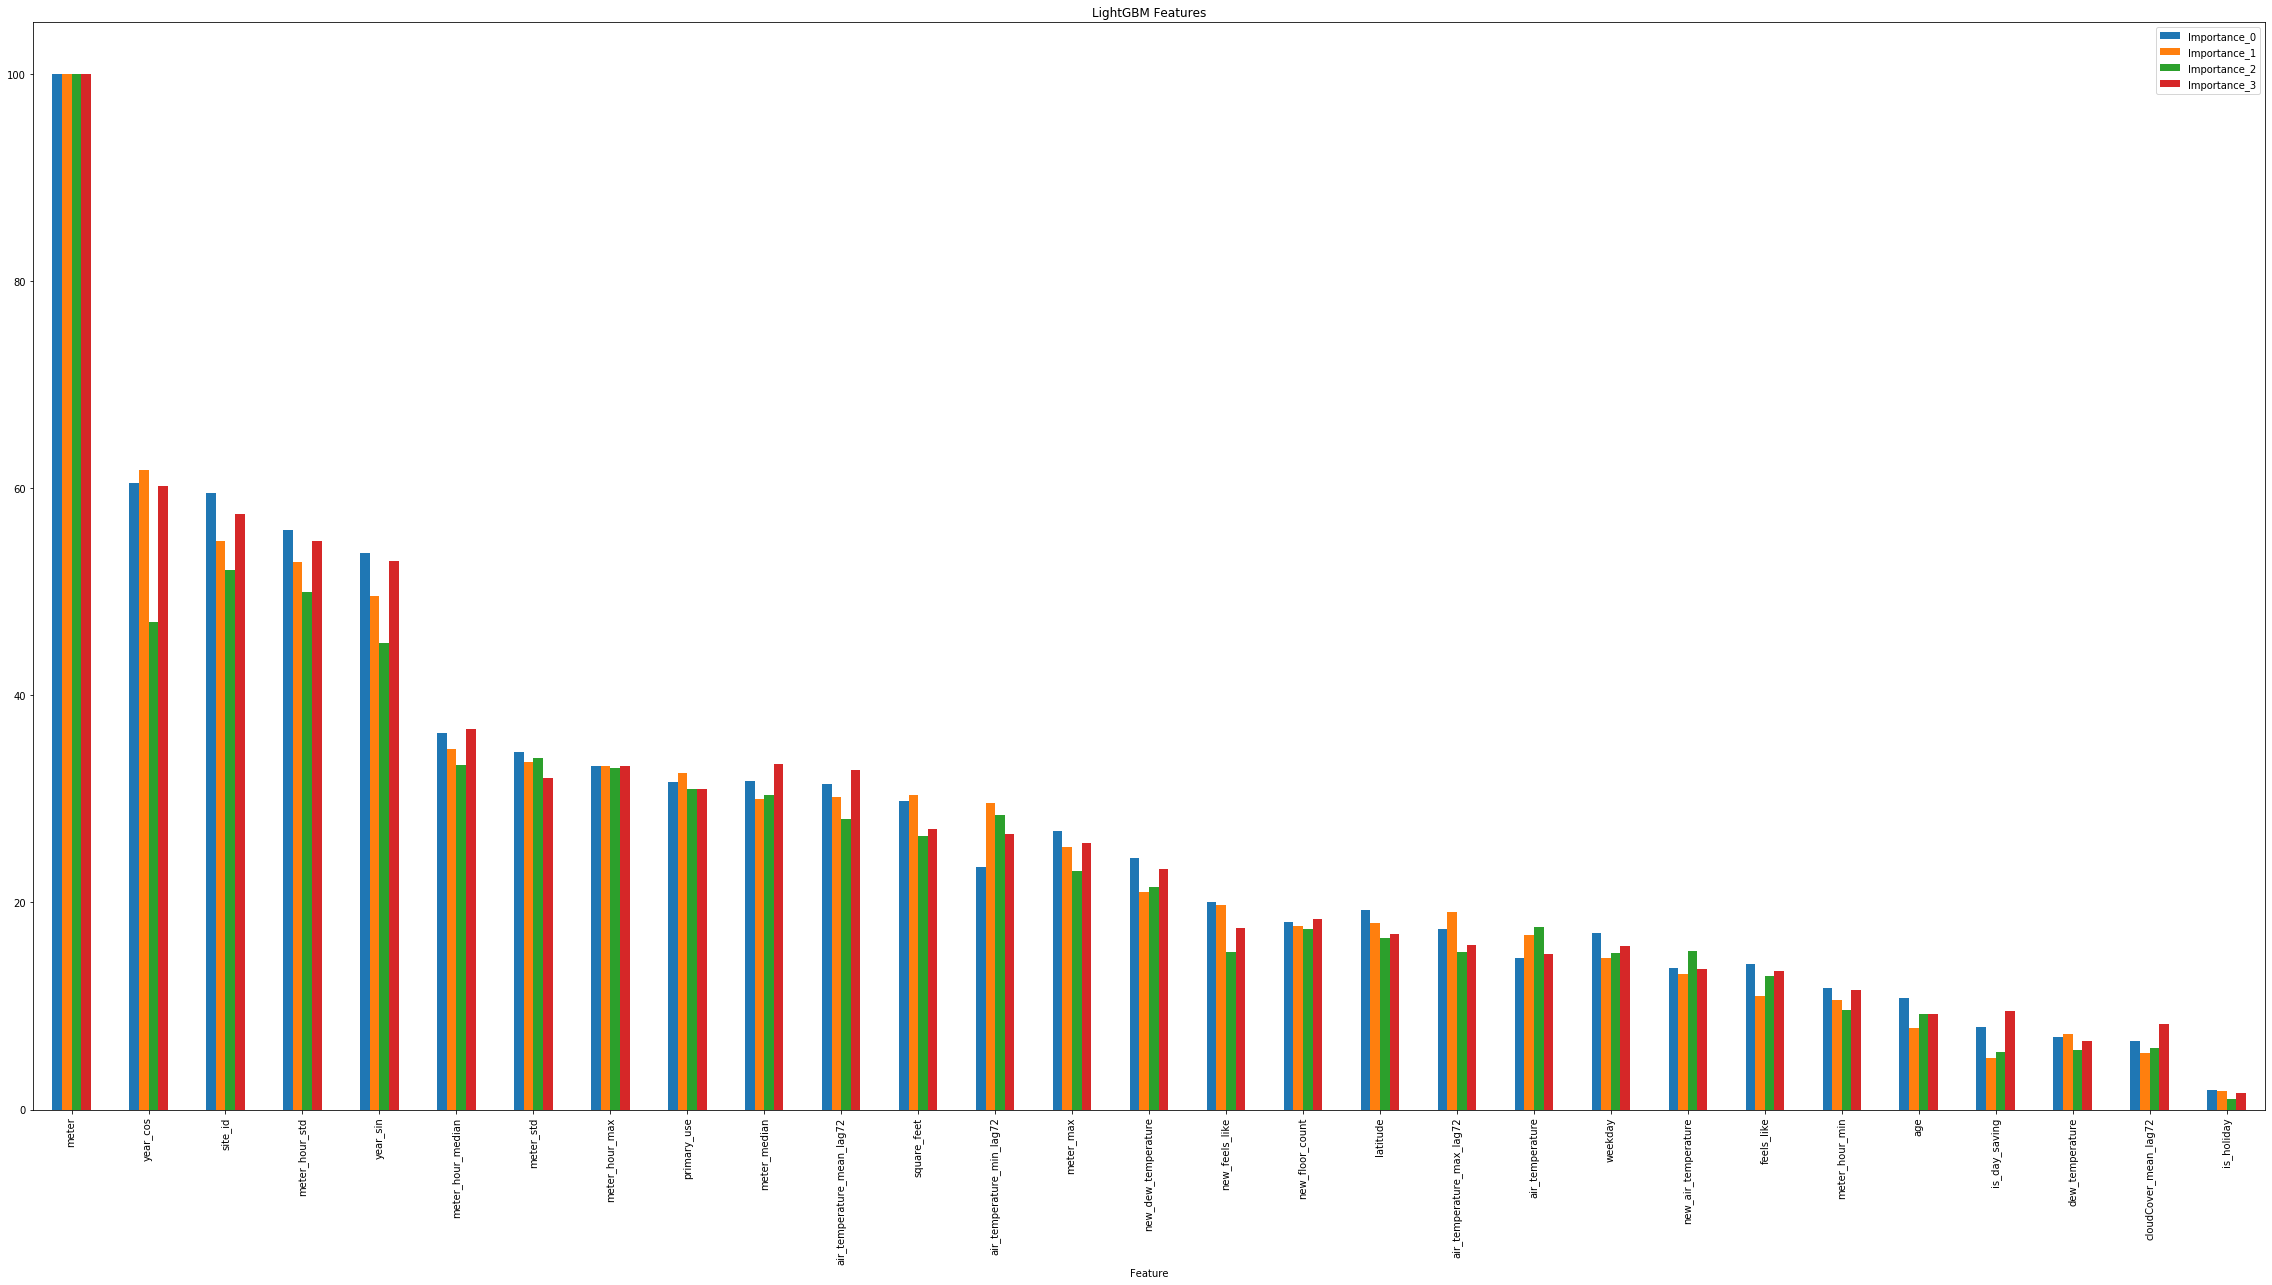

In [19]:
feature_imp[[col for col in feature_imp.columns if 'Importance' in col]].plot(figsize=(40, 20), kind='bar')
plt.title('LightGBM Features')
plt.show()

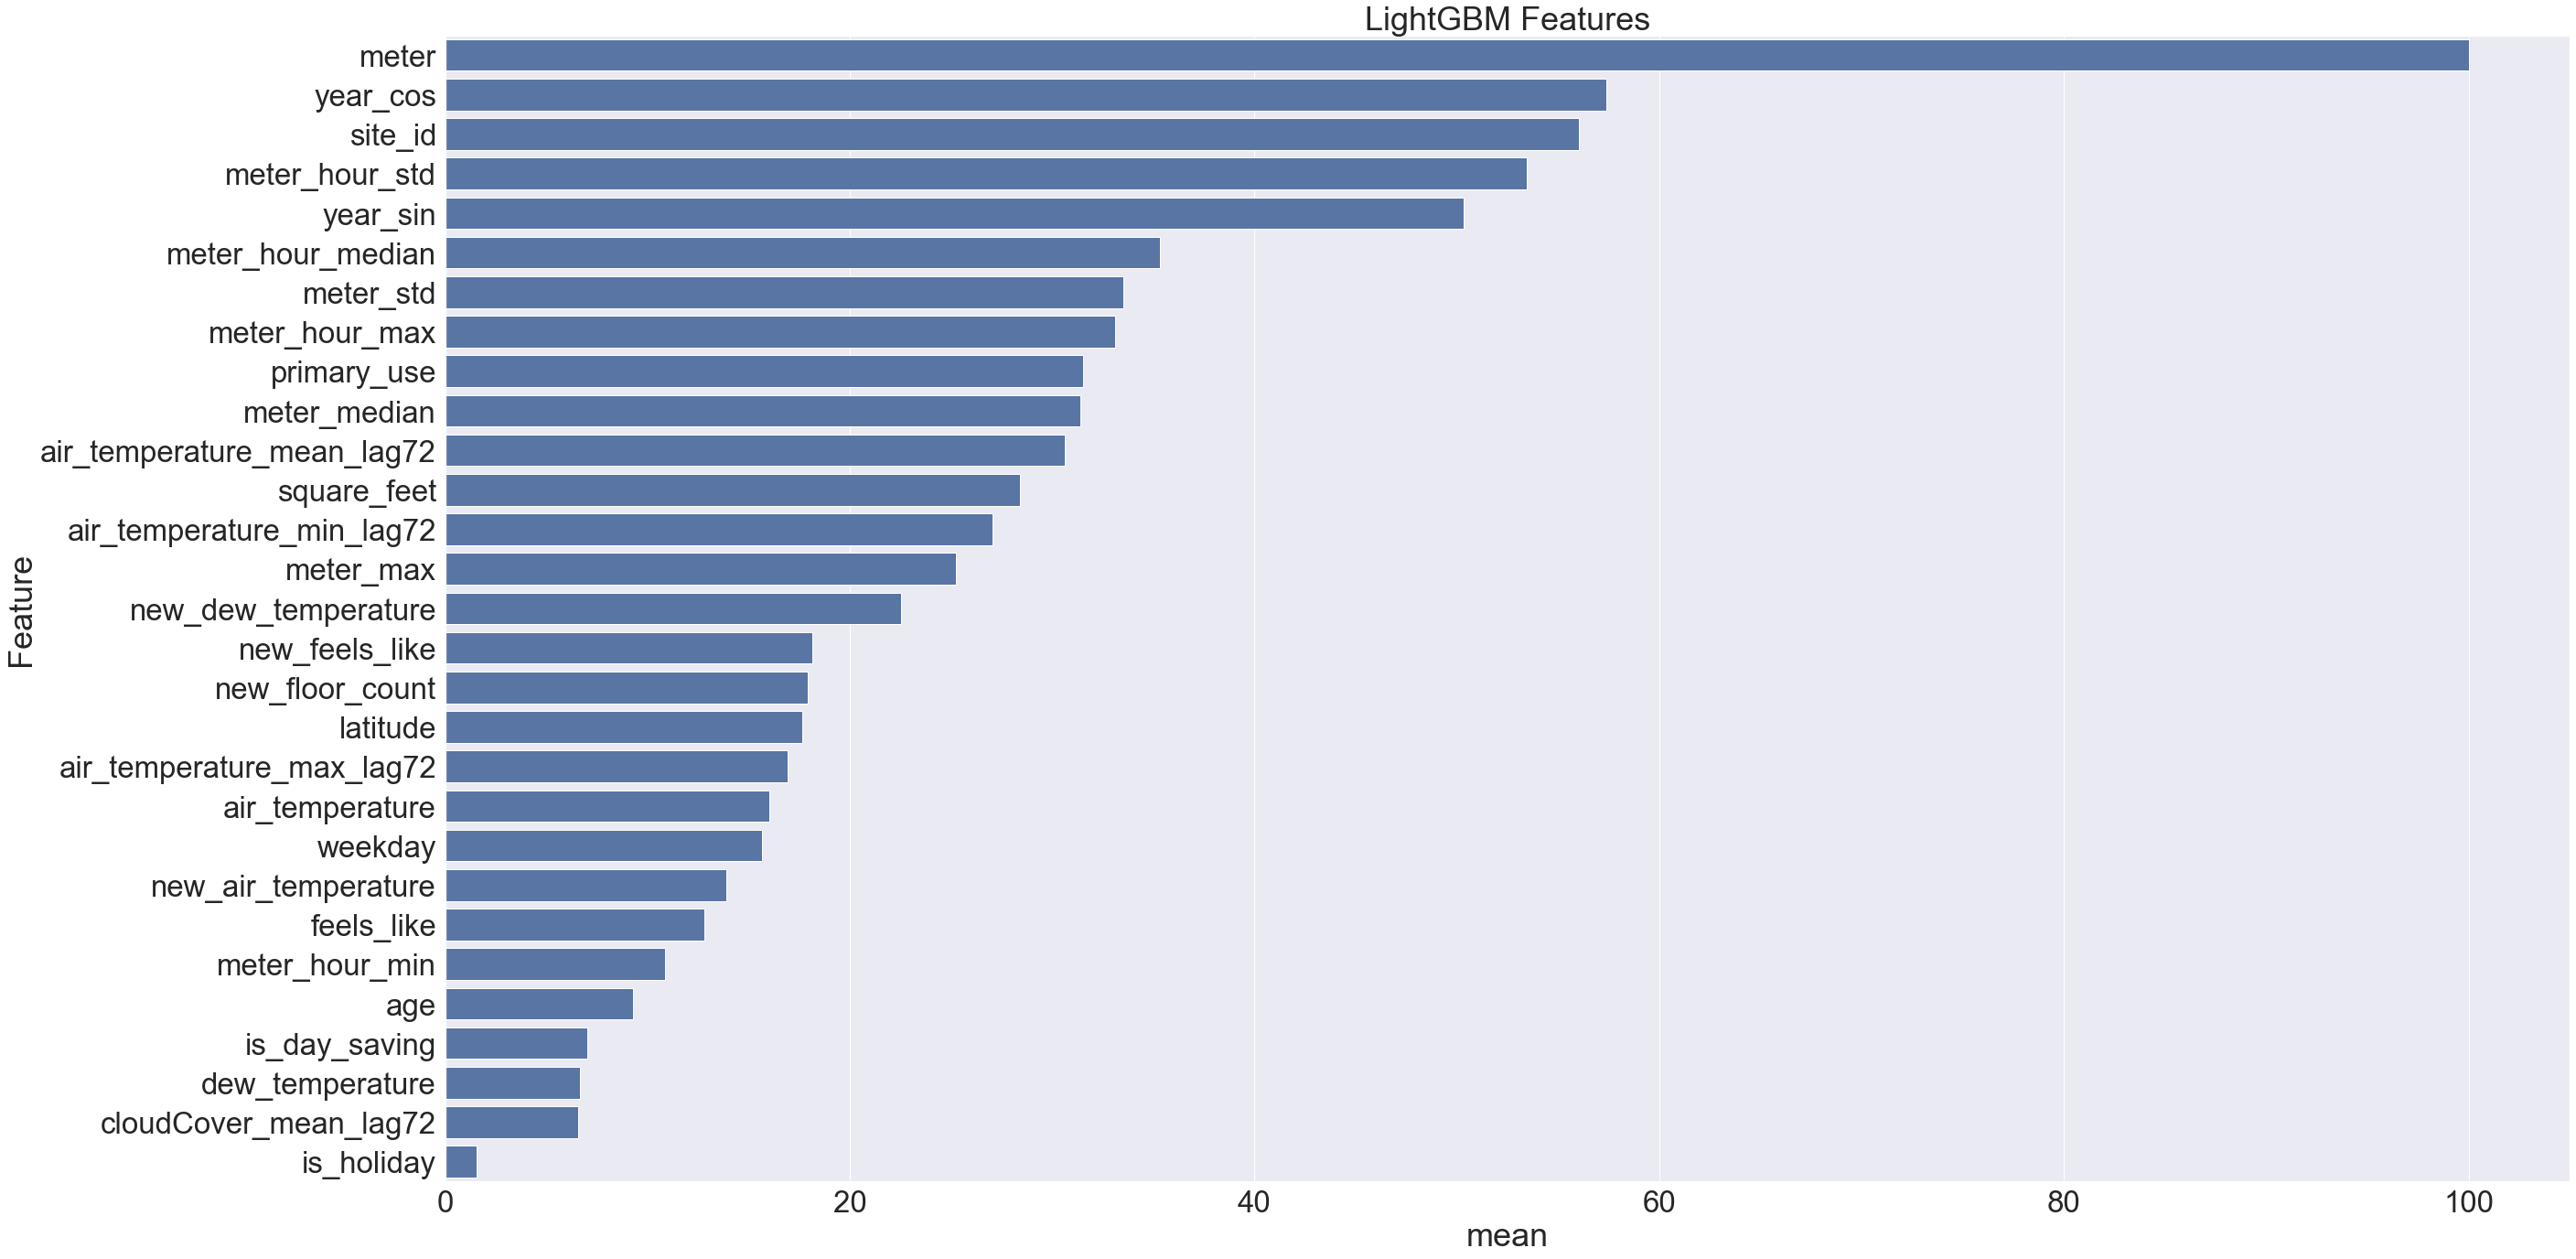

In [20]:
plt.figure(figsize=(40, 20))
sns.set(font_scale = 3)
sns.barplot(x="mean", y="Feature", data=feature_imp.sort_values(by="mean", 
                                                    ascending=False).reset_index(), color='C0')

plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [21]:
feature_imp[feature_imp['mean'].eq(0)].index

Index([], dtype='object', name='Feature')

In [22]:
feature_imp.to_csv(f'./models/feature_importance_v_{version}.csv')

In [23]:
feature_imp.tail(20)

,Importance_0,Importance_1,Importance_2,Importance_3,mean,max,min
Feature,,,,,,,
meter_median,31.740112,29.972907,30.426173,33.338164,31.369,33.338,29.973
air_temperature_mean_lag72,31.460398,30.224821,28.045543,32.797101,30.632,32.797,28.046
square_feet,29.826283,30.386425,26.389451,27.101449,28.426,30.386,26.389
air_temperature_min_lag72,23.422318,29.635439,28.468566,26.623188,27.037,29.635,23.422
meter_max,26.862302,25.329151,23.063769,25.753623,25.252,26.862,23.064
new_dew_temperature,24.325253,20.980085,21.502183,23.275362,22.521,24.325,20.980
new_feels_like,20.090293,19.782309,15.219837,17.574879,18.167,20.090,15.220
new_floor_count,18.151929,17.686202,17.465461,18.444444,17.937,18.444,17.465
latitude,19.226617,17.976140,16.547410,16.913043,17.666,19.227,16.547


# Retrain with all data

In [24]:
tr_data = lgb.Dataset(train[features],label=train[target])

gc.collect()
estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data],
            verbose_eval = 50)

model_filename = 'models/' + model_name + '_v_' + str(version) + '_fold_all.bin'
pickle.dump(estimator, open(model_filename, 'wb'))

del train, tr_data
gc.collect()

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.60945
[100]	training's rmse: 1.36088
[150]	training's rmse: 1.17907
[200]	training's rmse: 1.04784
[250]	training's rmse: 0.952092
[300]	training's rmse: 0.884385
[350]	training's rmse: 0.836266
[400]	training's rmse: 0.801769
[450]	training's rmse: 0.775626
[500]	training's rmse: 0.755318
[550]	training's rmse: 0.739682
[600]	training's rmse: 0.725788
[650]	training's rmse: 0.713173
Did not meet early stopping. Best iteration is:
[650]	training's rmse: 0.713173


183

In [25]:
version

'41'